In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('results.csv')

In [2]:
df

,info_about_run,training_dataset,text_tower_name,text_head_name,image_tower_name,image_head_name,text_tower_weight,text_head_weight,image_tower_weight,image_head_weight,...,imageNet_0shot_small_top_1,imageNet_0shot_small_top_5,imageNet_0shot_tiny_top_1,imageNet_0shot_tiny_top_5,flickr30l_image2text_top_1,flickr30l_image2text_top_5,flickr30l_image2text_top_10,flickr30l_text2image_top_1,flickr30l_text2image_top_5,flickr30l_text2image_top_10
0,baseline bad baseline,unknown (flickr?),BERT medium (42M),Projection Head,ViT small (22M),Projection Head,bad_baseline_text_enc_best_1.pt,bad_baseline_text_proj_best_1.pt,bad_baseline_img_enc_best_1.pt,bad_baseline_img_proj_best_1.pt,...,6.343907,22.537563,7.692308,38.461538,3.125000,15.625000,31.149194,3.125000,15.625000,31.250000
1,baseline: baseline,unknown (flickr?),BERT medium (42M),Projection Head,ViT small (22M),Projection Head,prajjwal1/bert-medium,baseline_text_proj_best_1.pt,facebook/dino-vits16,baseline_img_proj_best_1.pt,...,7.212020,28.914858,14.615385,52.307692,44.556452,83.568548,93.346774,46.975806,82.862903,94.254032
2,baseline: good baseline,unknown (flickr?),BERT medium (42M),Small MLP Head,ViT small (22M),Projection Head,prajjwal1/bert-medium,good_baseline_text_proj_best_1.pt,facebook/dino-vits16,good_baseline_img_proj_best_1.pt,...,5.809683,26.427379,16.794872,50.256410,43.951613,83.770161,94.556452,43.850806,83.064516,94.354839
3,baseline: APE,unknown (flickr?),BERT medium (42M),Medium MLP Head,ViT small (22M),Projection Head,prajjwal1/bert-medium,APE_text_proj_best_1.pt,facebook/dino-vits16,APE_img_proj_best_1.pt,...,6.677796,22.971619,18.205128,47.948718,40.524194,80.342742,93.245968,41.129032,80.241935,92.943548
4,"LST (medium/medium), random init",MSCOCO,BERT base (108M),Projection Head,ViT base (86M),Projection Head,LST_text_enc_best_baseBERT_ViTb_mscoco_LilT.pt,LST_text_proj_best_baseBERT_ViTb_mscoco_LilT.pt,LST_img_enc_best_baseBERT_ViTb_mscoco_LilT.pt,LST_img_proj_best_baseBERT_ViTb_mscoco_LilT.pt,...,2.954925,17.245409,7.820513,36.538462,3.528226,15.625000,31.854839,3.326613,16.330645,31.350806
5,"LST (medium/medium), smart init",MSCOCO,BERT base (108M),Projection Head,ViT base (86M),Projection Head,LST_text_enc_best_baseBERT_ViTb_mscoco_LilT_sm...,LST_text_proj_best_baseBERT_ViTb_mscoco_LilT_s...,LST_img_enc_best_baseBERT_ViTb_mscoco_LilT_sma...,LST_img_proj_best_baseBERT_ViTb_mscoco_LilT_sm...,...,5.075125,19.482471,7.307692,40.000000,2.923387,17.943548,32.762097,2.822581,19.153226,34.979839
6,"LST (I=medium/T=medium), longer training",unknown (MSCOCO?),BERT base (108M),Projection Head,ViT base (86M),Projection Head,LST_text_enc_best_LST_Imedium_Tmedium_complete.pt,LST_text_proj_best_LST_Imedium_Tmedium_complet...,LST_img_enc_best_LST_Imedium_Tmedium_complete.pt,LST_img_proj_best_LST_Imedium_Tmedium_complete.pt,...,9.799666,35.525876,22.435897,63.333333,39.818548,77.620968,90.725806,42.540323,76.814516,88.508065
7,"LST (I=medium/T=medium), shorter training",unknown (MSCOCO? or maybe flickr?),BERT base (108M),Projection Head,ViT base (86M),Projection Head,LST_text_enc_best_LST_Imedium5_Tmedium3.pt,LST_text_proj_best_LST_Imedium5_Tmedium3.pt,LST_img_enc_best_LST_Imedium5_Tmedium3.pt,LST_img_proj_best_LST_Imedium5_Tmedium3.pt,...,9.632721,35.242070,25.384615,68.974359,34.072581,71.068548,85.987903,34.576613,70.463710,83.266129
8,LST (I=medium/T=small),unknown (MSCOCO?),BERT medium (42M),Projection Head,ViT base (86M),Projection Head,LST_text_enc_best_LST_Imedium_Tsmall.pt,LST_text_proj_best_LST_Imedium_Tsmall.pt,LST_img_enc_best_LST_Imedium_Tsmall.pt,LST_img_proj_best_LST_Imedium_Tsmall.pt,...,6.043406,30.016694,18.205128,54.615385,24.495968,62.600806,80.745968,24.395161,62.399194,79.838710
9,LST (I=medium/T=small),"unknown (MSCOCO?), special lr5",BERT medium (42M),Projection Head,ViT base (86M),Projection Head,LST_text_enc_best_LST_Imedium_Tsmall_lr5.pt,LST_text_proj_best_LST_Imedium_Tsmall_lr5.pt,LST_img_enc_best_LST_Imedium_Tsmall_lr5.pt,LST_img_proj_best_LS

Columns in the DataFrame: Index(['info_about_run', 'text_tower_name', 'text_head_name',
       'image_tower_name', 'image_head_name', 'text_tower_params',
       'text_head_params', 'image_tower_params', 'image_head_params',
       'text_tower_trainable_params', 'text_head_trainable_params',
       'image_tower_trainable_params', 'image_head_trainable_params',
       'memory_before_model', 'memory_for_model', 'memory_forward_pass',
       'mem_after_loss_gradient', 'mem_after_loss_backward',
       'mem_after_optimizer'],
      dtype='object')
             info_about_run    text_tower_name   text_head_name  \
0    LoRA (I=small/T=small)  BERT medium (42M)  Projection Head   
1   LoRA (I=small/T=medium)   BERT base (108M)  Projection Head   
2   LoRA (I=medium/T=small)  BERT medium (42M)  Projection Head   
3  LoRA (I=medium/T=medium)   BERT base (108M)  Projection Head   
4   LST (I=medium/T=medium)   BERT base (108M)  Projection Head   

  image_tower_name  image_head_name  text_tower

KeyError: 'Variant'

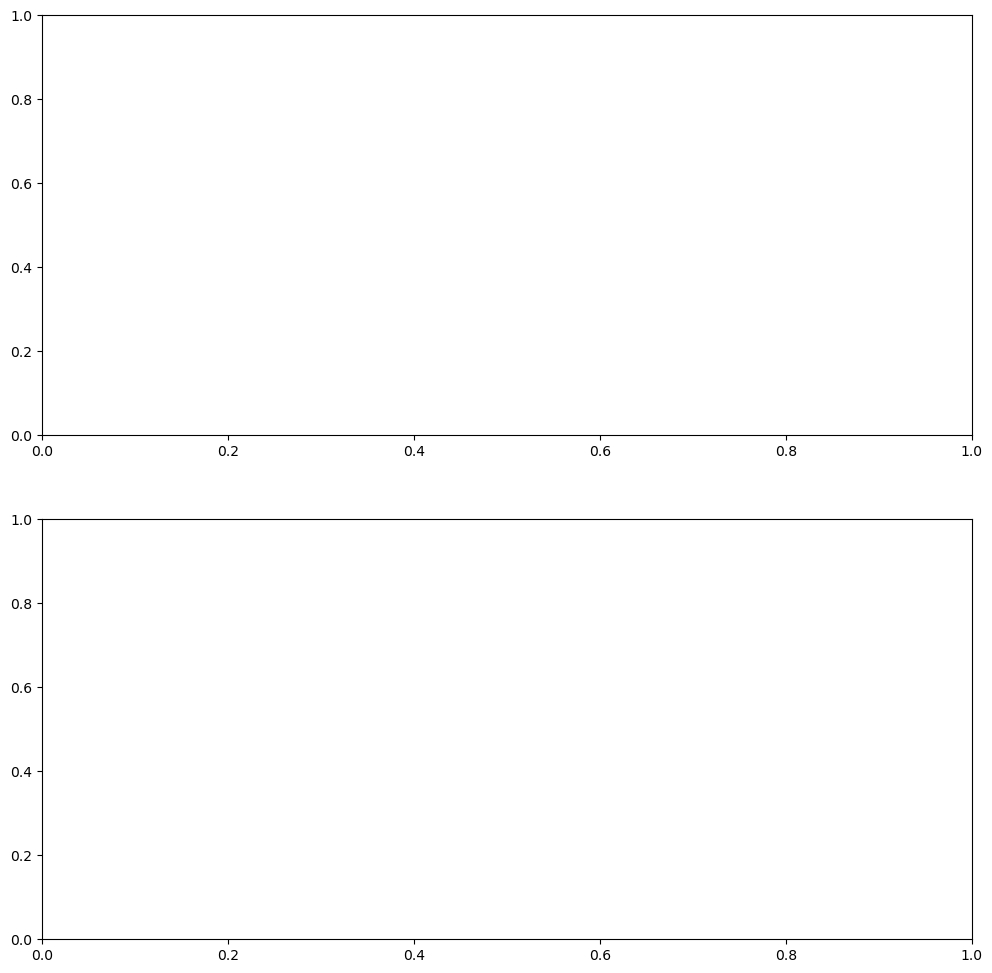

In [4]:

# Load the dataset from the CSV file
df = pd.read_csv('memory.csv')

# Print the first few rows and column names to understand the structure of your dataset
print("Columns in the DataFrame:", df.columns)
print(df.head())

# Assuming your dataset has the following columns (adjust if needed):
# 'Model' for model names
# 'Variant' for size variants (e.g., small, medium, large, xlarge)
# 'Memory_Usage_1', 'Memory_Usage_2', ... for different memory usage metrics

# Replace the actual column names from your CSV
model_col = 'Model'
variant_col = 'Variant'
memory_usage_cols = [col for col in df.columns if 'Memory_Usage' in col]

# Set up the plot for memory usage across different metrics
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plotting memory usage across different metrics
df_pivot = df.pivot(index=variant_col, columns=model_col, values=memory_usage_cols)
df_pivot.plot(kind='bar', ax=axes[0])
axes[0].set_title('Memory Usage Across Different Metrics')
axes[0].set_xlabel('Variant')
axes[0].set_ylabel('Memory Usage (GB)')

# Plotting memory usage per model variant
for model in df[model_col].unique():
    model_data = df[df[model_col] == model]
    model_data.plot(x=variant_col, y=memory_usage_cols, kind='bar', ax=axes[1], label=model, alpha=0.7)

axes[1].set_title('Memory Usage per Model Variant')
axes[1].set_xlabel('Variant')
axes[1].set_ylabel('Memory Usage (GB)')
axes[1].legend(df[model_col].unique())

plt.tight_layout()
plt.show()


## DataSet

In [1]:
from dataloader import get_dataloader
import config as CFG
from tokenizer import get_tokenizer,get_feature_extractor

In [2]:
from torchvision.datasets.utils import download_url


In [3]:
val = 'https://storage.googleapis.com/sfr-vision-language-research/datasets/flickr30k_val.json'
download_url(val,CFG.ann_root)

Using downloaded and verified file: ./flickr30k/flickr30k_val.json


## Model

In [1]:
1024%1000

24

In [2]:
8*500/60

66.66666666666667

In [5]:
from models import CLIPModel
from losses import CLIPLoss

In [4]:
from transformers import BertModel, BertConfig


In [11]:
test = CLIPModel()

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the

In [5]:
model_name = "prajjwal1/bert-medium"

In [6]:
model = BertModel.from_pretrained(model_name)


Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
model2 = BertModel(config=BertConfig.from_pretrained(model_name))

In [9]:
model3 = BertModel.from_pretrained(pretrained_model_name_or_path=model_name,config=BertConfig.from_pretrained(model_name))

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Not new

In [3]:
from dataset import get_dataset
from training import valid_one_epoch
import os
import config as CFG
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import wandb

In [6]:
transform_train = transforms.Compose([
            transforms.RandomCrop(224,pad_if_needed=True),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.444, 0.421, 0.385), 
                                 (0.285, 0.277, 0.286))])

In [7]:
tokenizer = get_tokenizer(CFG.text_model_name)
ds_train = get_dataset(tokenizer=tokenizer,transform=transform_train,split="train")
ds_val = get_dataset(tokenizer=tokenizer,transform=transform_train,split="val")
ds_test = get_dataset(tokenizer=tokenizer,transform=transform_train,split="test")

Using downloaded and verified file: ./flickr30k/flickr30k_train.json
Using downloaded and verified file: ./flickr30k/flickr30k_val.json
Using downloaded and verified file: ./flickr30k/flickr30k_test.json


In [12]:
print(ds_train.__getitem__(0)["image"].shape)
print(ds_train.__getitem__(0)["input_ids"].shape)
print(ds_val.__getitem__(0)["image"].shape)
print(ds_val.__getitem__(0)["input_ids"].shape)
print(ds_test.__getitem__(0)["image"].shape)
print(ds_test.__getitem__(0)["input_ids"].shape)


torch.Size([3, 224, 224])
torch.Size([128])
torch.Size([3, 224, 224])
torch.Size([128])
torch.Size([3, 224, 224])
torch.Size([128])


In [2]:
dataloader_valid = get_dataloader(tokenizer=tokenizer,batch_size=CFG.batch_size,shuffle=CFG.shuffle_train,num_workers=CFG.num_workers,split="val")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CLIPModel().to(device)
loss_fn = CLIPLoss()

NameError: name 'get_dataloader' is not defined

In [17]:
wandb.init(project="master_test_1",
           config={
               "batch_size": CFG.batch_size,
               "learning_rate": CFG.head_lr,
               "dataset": "flickr30k",
           },
           group="group_test")
    
valid_loss = valid_one_epoch(model,loss_fn,dataloader_valid,device)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: carrelv. Use `wandb login --relogin` to force relogin


100%|██████████| 1/1 [00:05<00:00,  5.84s/it, valid_loss=6.94]


In [21]:
valid_loss.avg_text_l

tensor([[-0.0927,  0.3875, -0.1741,  ...,  0.0377,  0.0927, -0.1575],
        [-0.1718,  0.1364, -0.2955,  ..., -0.2148, -0.1264, -0.2588],
        [-0.0938,  0.0679, -0.3672,  ...,  0.0347,  0.0078, -0.3171],
        ...,
        [-0.3468,  0.3004, -0.2342,  ..., -0.1646, -0.2120, -0.2403],
        [-0.0600,  0.5362,  0.0269,  ..., -0.0285,  0.1017, -0.2270],
        [-0.2309,  0.0847, -0.0814,  ..., -0.4008, -0.2727, -0.2470]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [6]:
tokenizer = get_tokenizer(CFG.text_model_name)
feature_extractor = get_feature_extractor(CFG.vision_model_name)

dataloader_train = get_dataloader(tokenizer=tokenizer,feature_extractor=feature_extractor,batch_size=CFG.batch_size,shuffle=CFG.shuffle_train,num_workers=CFG.num_workers,split="train")
dataloader_valid = get_dataloader(tokenizer=tokenizer,feature_extractor=feature_extractor,batch_size=CFG.batch_size,shuffle=CFG.shuffle_train,num_workers=CFG.num_workers,split="val")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CLIPModel().to(device)
loss_fn = CLIPLoss()

Using downloaded and verified file: ./flickr30k/flickr30k_train.json
Using downloaded and verified file: ./flickr30k/flickr30k_val.json


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the

In [16]:
test = next(iter(dataloader_train))

In [17]:
test["image"].shape

torch.Size([1024, 1, 3, 224, 224])

In [11]:

transform_train = transforms.Compose([
            transforms.RandomCrop(224,pad_if_needed=True),
            transforms.RandomHorizontalFlip(), 
            ])

In [12]:
dataset = get_dataset(tokenizer=tokenizer,feature_extractor=feature_extractor,transform=transform_train,split="train")

Using downloaded and verified file: ./flickr30k/flickr30k_train.json


In [13]:
test = dataset.__getitem__(0)

In [15]:
test["image"].shape

torch.Size([1, 3, 224, 224])

In [38]:
test["input_ids"].shape

torch.Size([128])

In [28]:
test["image"][0].shape

torch.Size([1024, 3, 224, 224])

## DDP

In [7]:
from torchvision.datasets.utils import download_url
from torch.utils.data import  Dataset
import json
from dataset import pre_caption
import config as CFG
from torchvision.datasets import Flickr30k
import random

In [38]:

class flickr30k_test(Dataset):
    def __init__(self, tokenizer,transform,image_root, ann_root, split, max_words=CFG.max_length, prompt=CFG.prompt):        
        '''
        image_root (string): Root directory of images (e.g. data/)
        ann_root (string): directory to store the annotation file
        split (string): one of "train" or "test"
        '''        
        train = 'https://storage.googleapis.com/sfr-vision-language-research/datasets/flickr30k_train.json'
        test = 'https://storage.googleapis.com/sfr-vision-language-research/datasets/flickr30k_test.json'

        self.tokenizer = tokenizer

        self.split = split
        assert self.split in ("train","test")

        if self.split == "train":
            url = train
            filename = 'flickr30k_train.json'
        else:
            url = test
            filename = 'flickr30k_test.json'

        download_url(url,ann_root)
        
        self.annotation = json.load(open(os.path.join(ann_root,filename),'r'))
        self.transform = transform
        self.image_root = image_root
        self.max_words = max_words      
        self.prompt = prompt
        
        self.img_ids = {} 

        for ann in self.annotation:
            img_id = ann['image_id']
            if img_id not in self.img_ids.keys():
                self.img_ids[img_id] = ann
                self.img_ids[img_id]["caption"] = [self.img_ids[img_id]["caption"]]
            
            else: 
                ls = self.img_ids[img_id]["caption"]
                ls.append(ann["caption"])               
                self.img_ids[img_id]["caption"] = ls

        self.annotation = None
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, index):    
        
        item = self.img_ids[index]
        
        image_path = os.path.join(self.image_root,item['image'])        
        image = Image.open(image_path).convert('RGB')   
        image = self.transform(image)
        
        caption = self.prompt+pre_caption(random.choice(item['caption']), self.max_words)
        
        caption_encoded = self.tokenizer(caption,padding="max_length",max_length=self.max_words)

        return {"image" :image, "input_ids": torch.as_tensor(caption_encoded["input_ids"]), "attention_mask": torch.as_tensor(caption_encoded["attention_mask"])}

In [39]:
ds = flickr30k_test(tokenizer=tokenizer,transform=transform_train,image_root=CFG.image_root,ann_root=CFG.ann_root,split="train")

Using downloaded and verified file: ./flickr30k/flickr30k_train.json


In [40]:
ds.__getitem__(0)

NameError: name 'Image' is not defined

In [36]:
random.choice(ds.img_ids[0]["caption"])

'Two young, White males are outside near many bushes.'

In [31]:
from dataset import flickr30k

In [32]:
ds2 = flickr30k(tokenizer=tokenizer,transform=transform_train,image_root=CFG.image_root,ann_root=CFG.ann_root,split="train")

Using downloaded and verified file: ./flickr30k/flickr30k_train.json


In [25]:
ds2.annotation[:5]

[{'image': 'flickr30k-images/1000092795.jpg',
  'caption': 'Two young guys with shaggy hair look at their hands while hanging out in the yard.',
  'image_id': 0},
 {'image': 'flickr30k-images/1000092795.jpg',
  'caption': 'Two young, White males are outside near many bushes.',
  'image_id': 0},
 {'image': 'flickr30k-images/1000092795.jpg',
  'caption': 'Two men in green shirts are standing in a yard.',
  'image_id': 0},
 {'image': 'flickr30k-images/1000092795.jpg',
  'caption': 'A man in a blue shirt standing in a garden.',
  'image_id': 0},
 {'image': 'flickr30k-images/1000092795.jpg',
  'caption': 'Two friends enjoy time spent together.',
  'image_id': 0}]